# Assignment 2 – Zero-Shot Image Classification with Transformers

In this assignment, you will apply a pre-trained vision–language transformer (e.g. CLIP) to perform **zero-shot** classification on the Fashion-MNIST dataset—classifying each image without any task-specific training. You will build on the concepts from Assignment 1 by comparing this “off-the-shelf” approach to the CNN you previously trained.

You will:
1. **Load** the Fashion-MNIST images using PyTorch instead of Keras.
2. **Run a zero-shot baseline** with simple text prompts to set a performance reference.
3. **Engineer improved prompts** and measure the resulting accuracy gains.
4. **Visualise image embeddings** with UMAP to inspect class separability.
5. **Conduct one mini-experiment** of your choice.
6. **Summarise findings** and reflect on strengths and weaknesses of zero-shot transformers versus a trained CNN.

# 1. Loading the Fashion-MNIST Dataset

As in assignment 1, we'll load the Fashion-MNIST dataset, but this time using `torchvision.datasets` to ensure compatibility with the `transformers` library. We will also load our model and processor from the `transformers` library.

The transformers library allows us to use pre-trained models like CLIP, which can perform zero-shot classification by leveraging the text prompts we provide. There are two key objects we will use: the `CLIPModel` for the model itself and the `CLIPProcessor` for preparing our images and text prompts.

Since we are not actually training a model in this assignment, we will set the CLIP model to evaluation mode. If the model is designed to utilize features like dropout or batch normalization, setting it to evaluation mode ensures that these features behave correctly during inference (prediction). Setting the model to evaluaton mode also tells PyTorch that we don't have to compute gradients, which can save memory and speed up inference.

In order to speed up processing, we will also move the model to an "accelerator" if available. This is typically a GPU, but modern MacBooks also have an "Apple Silicon" accelerator that can be used for inference, called MPS (Metal Performance Shaders). If you are using a MacBook with Apple Silicon, you can use the MPS device for faster processing.

In [18]:
# Uncomment and run if required
#!pip install transformers torchvision torch accelerate

In [1]:
from transformers import CLIPModel, CLIPProcessor
import torch

clip_model_name = "openai/clip-vit-base-patch32"
clip_model     = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name, use_fast=False)

# Set model to evaluation mode, as we are not training it
clip_model.eval()

# Check for accelerators
device = "cpu" # Default to CPU
if torch.cuda.is_available():
    device = "cuda" # Use GPU if available
elif torch.backends.mps.is_available():
    device = "mps"

clip_model.to(device)

print(f"Using device: {device}")

Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Using device: cpu


Now we are ready to load the testing set from Fashion-MNIST. We will use the `torchvision.datasets.FashionMNIST` class to load the dataset. We do not need to apply any transformations to the images, as the `CLIPProcessor` ensures any input images are in the format that the model is trained on.

You should:

- [ ] Use the `torchvision.datasets.FashionMNIST` class to load the *test* split of the dataset. Documentation is available [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).
- [ ] Create a PyTorch `DataLoader` to iterate over the dataset in batches. Use a batch size of 16 and set `shuffle=True` to randomise the order of the images. You will also need to supply the provided `collate_clip` function to the `DataLoader collate_fn` argument to ensure the images are processed correctly. Documentation for `DataLoader` is available [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [2]:
from torchvision import datasets
from torch.utils.data import DataLoader

CLASS_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

def collate_clip(batch):
    imgs, labels = zip(*batch) # Unzip the batch into images and labels
    proc = clip_processor(images=list(imgs),
                        return_tensors="pt",
                        padding=True) # Process images with CLIPProcessor
    # Send pixel_values to GPU/CPU now; labels stay on CPU for metrics
    return proc["pixel_values"].to(device), torch.tensor(labels)

# download the dataset
test_dataset = datasets.FashionMNIST(
    root = './data', # data directory
    train = False,   # test only
    download = False  # set to False if already downloaded 
)

# DataLoader for batch processing
test_loader = DataLoader(
    dataset = test_dataset,     
    batch_size = 16,            
    shuffle = True,             # randomize image order
    collate_fn = collate_clip   # clip_processor
)

In [4]:
print(f"Test dataset size: {len(test_dataset)}\n"
      f"Batch size: {test_loader.batch_size}\n"
      f"Total # of batches: {len(test_loader)}\n"
      f"Class size: {len(CLASS_NAMES)}") 

Test dataset size: 10000
Batch size: 16
Total # of batches: 625
Class size: 10


If your code is correct, the following cell should show the first batch of images from the Fashion-MNIST dataset:

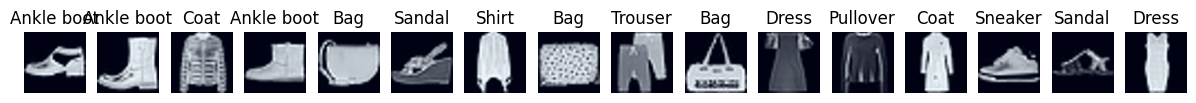

In [5]:
import matplotlib.pyplot as plt

# Display the first batch of images from `test_loader`

def show_batch(loader):
    images, labels = next(iter(loader))
    images = images.cpu()  # Move images to CPU for plotting
    # Renormalize to [0, 1] for visualization
    images = (images - images.min()) / (images.max() - images.min())
    _, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(CLASS_NAMES[label.item()])
        ax.axis('off')
    plt.show()

show_batch(test_loader)

We’re now ready to run our zero-shot classification baseline!

# Brief Introduction to Zero-Shot Classification

In Assignment 1, we followed the typical machine-learning pipeline: we trained a CNN on the Fashion-MNIST dataset, using labelled examples to update the model’s weights. While effective, that approach requires a curated, task-specific training set—a luxury you don’t always have in practice.

Zero-shot classification flips the script.  A large vision–language model (VLM) such as **CLIP** is first pre-trained on hundreds of millions of image–text pairs scraped from the web.  Because it learns *joint* visual–textual embeddings, the model can later solve new tasks simply by “measuring” how similar an image is to a **text prompt** that describes each candidate class—without seeing a single task-labelled example.

**How it works**  
1. Feed an image through CLIP’s vision encoder → **image feature**.  
2. Feed a textual prompt (e.g. “a photo of a sandal”) through CLIP’s text encoder → **text feature**.  
3. Compute cosine similarity between the image feature and every class’s text feature.  
4. Pick the class whose prompt is most similar.

For our first attempt, we’ll use the bare class names as prompts, e.g.:

- "T-shirt/top"
- "Trouser"

### You should:

- [ ] Build embeddings: use the `get_text_embeddings` helper function to create text embeddings for the class names.
- [ ] Run inference: use the `get_image_embeddings` helper function to create image embeddings.
- [ ] Compute cosine similarity: complete and use the `get_cosine_similarity` helper function to compute the cosine similarity between the image and text embeddings.
- [ ] Make predictions: use the `get_predictions` helper function to get the predicted class for each image in the batch.

Note that for normalized vectors like the ones we are using, cosine similarity is equivalent to the dot product. This means we can use the handy formula `cosine_similarity = vector_a @ vector_b.T` to compute the similarity between the image and text embeddings.

In [6]:
def get_text_embeddings(class_names: list[str]) -> torch.Tensor:
    """    Get text embeddings for the given class names using CLIP.
    Args:
        class_names (list[str]): List of class names to encode.
    Returns:
        torch.Tensor: Normalized text embeddings for the class names.
    """
    tokenized = clip_processor(text=class_names,
                               padding=True,
                               return_tensors="pt").to(device)
    
    with torch.no_grad():
        text_embeddings = clip_model.get_text_features(**tokenized)

    text_feats = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

    return text_feats

def get_image_embeddings(images: torch.Tensor) -> torch.Tensor:
    """    Get image embeddings for the given images using CLIP.
    Args:
        images (torch.Tensor): Batch of images to encode.
    Returns:
        torch.Tensor: Normalized image embeddings for the images.
    """
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(pixel_values=images)

    image_feats = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

    return image_feats

In [7]:
import numpy as np

def get_cosine_similarity(image_feats: torch.Tensor, text_feats: torch.Tensor) -> np.ndarray:
    """
    Compute cosine similarity between image features and text features.
    Args:
        image_feats (torch.Tensor): Image features of shape (N, D).
        text_feats (torch.Tensor): Text features of shape (M, D).
    Returns:
        numpy.ndarray: Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    """
    image_feats = image_feats.cpu()  # Ensure image features are on CPU
    text_feats = text_feats.cpu()    # Ensure text features are on CPU

    # Compute cosine similarity, which is the dot product of normalized vectors
    return (image_feats @ text_feats.T).numpy() # convert from tensor to numpy

def get_predictions(similarity: np.ndarray) -> np.ndarray:
    """
    Get predictions based on cosine similarity scores.
    Args:
        similarity (numpy.ndarray): Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    Returns:
        numpy.ndarray: Predicted class indices for each image, shape (N,).
    """
    # Get the index of the maximum similarity for each image
    return np.argmax(similarity, axis=1) # axis=0 is image, axis=1 is label

With these functions complete, you are ready to run the zero-shot classification baseline. Complete the code to follow these steps:

- [ ] Build text embeddings for the class names using the `get_text_embeddings` function (this only needs to be done once).
- [ ] For each batch of images:
    - [ ] Get image embeddings using the `get_image_embeddings` function.
    - [ ] Compute cosine similarity between the image and text embeddings using the `get_cosine_similarity` function.
    - [ ] Save the predictions so that we can build a confusion matrix later.
- [ ] Report the accuracy of the predictions and the confusion matrix using the `accuracy_score` and `confusion_matrix` functions from `sklearn.metrics`.

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix

# 1. Build text embeddings for class names
text_embeddings = get_text_embeddings(CLASS_NAMES)

# 2. Get classification predictions for each batch
y_true, y_pred = [], []

for pixel_values, labels in test_loader:

    # Get image embeddings
    image_embeddings = get_image_embeddings(pixel_values)

    # Compute cosine similarity between image and text embeddings
    similarity = get_cosine_similarity(image_embeddings, text_embeddings)

    # Get and store predictions
    predictions = get_predictions(similarity)
    y_pred.extend(predictions) # .append is slow
    
    # Store ground truth
    y_true.extend(labels.numpy()) # convert from tensor to np

# convert to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Report the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

AttributeError: 'BaseModelOutputWithPooling' object has no attribute 'norm'

RESULTS: BASELINE ZERO-SHOT CLASSIFICATION 
--------------
TEST ACCURACY 
--------------
Overall: 	62.40%

T-shirt/top     76.90%
Trouser         93.10%
Pullover        30.60%
Dress           50.40%
Coat            69.00%
Sandal          39.30%
Shirt           4.20%
Sneaker         95.00%
Bag             95.80%
Ankle boot      69.70%


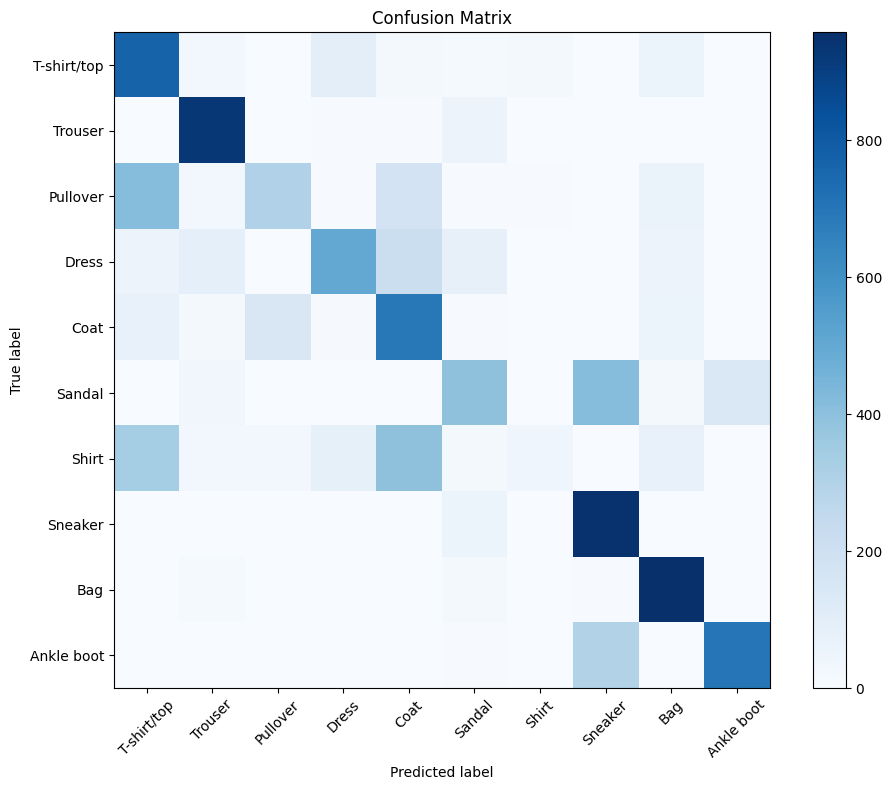

-------------------------
CONFUSIONS > CHANCE (10%)
-------------------------
Pullover   => T-shirt/top  41.50%
Pullover   => Coat         17.40%
Dress      => Coat         21.60%
Coat       => Pullover     14.30%
Sandal     => Sneaker      41.40%
Sandal     => Ankle boot   14.10%
Shirt      => T-shirt/top  33.80%
Shirt      => Coat         39.40%
Ankle boot => Sneaker      29.70%

-------------------------------
MODEL COMPARISON: TEST ACCURACY
-------------------------------
Baseline Zero-Shot CLIP:	62.40%
Trained CNN Classifier (A1): 	90.65%
Model accuracy difference: 	-28.25%


In [26]:
# RESULTS: ACCURACY
msg = "results: baseline zero-shot classification "
headr = "="*(len(msg))
print(f"{headr}\n{msg.upper()}\n{headr}")

msg = "test accuracy "
headr = "-"*(len(msg))
print(f"{headr}\n{msg.upper()}\n{headr}")

cm = confusion_matrix(y_true, y_pred)
class_acc = np.diag(cm)/cm.sum(axis=1)

# Report the accuracy of the predictions
print(f"Overall: \t{accuracy_score(y_true,y_pred)*100:.2f}%\n")
for item, score in list(zip(CLASS_NAMES,class_acc.tolist())):
    print(f"{item:<15} {score*100:.2f}%")

# RESULTS: CONFUSIONS
plot_confusion_matrix(y_true,y_pred, CLASS_NAMES)

msg = "confusions > chance (10%)"
headr = "-"*(len(msg))
print(f"{headr}\n{msg.upper()}\n{headr}")

# Normalize rows to percentages
row_sums = cm.sum(axis=1, keepdims=True) 

percent_matrix = np.divide(
    cm,
    row_sums,
    out=np.zeros_like(cm, dtype=float),
    where=row_sums != 0
) * 100

percent_no_diag = percent_matrix.copy()
np.fill_diagonal(percent_no_diag, 0)

rows, cols = np.where(percent_no_diag > len(CLASS_NAMES))

for r, c in zip(rows, cols):
    print(f"{CLASS_NAMES[r]:<10} => {CLASS_NAMES[c]:<12} {percent_no_diag[r, c]:.2f}%")

# RESULTS: MODEL COMPARISON
msg = "Model Comparison: test accuracy"
headr = "-"*(len(msg))
print(f"\n{headr}\n{msg.upper()}\n{headr}")

CNN_acc = 90.65
ZSC_acc = accuracy_score(y_true,y_pred)*100

print(f"Baseline Zero-Shot CLIP:\t{ZSC_acc:.2f}%\n"
      f"Trained CNN Classifier (A1): \t{CNN_acc:.2f}%")
print(f"Model accuracy difference: \t{ZSC_acc - CNN_acc:.2f}%")


Reflection: Consider the results. How does the performance of this zero-shot baseline compare to the CNN you trained in Assignment 1? What are the strengths and weaknesses of this approach?

> The zero-shot baseline classifer scores lower on test accuracy (62.40%) compared to the trained CNN classifer (90.65%), a performance decrease of 28.25%. One strength of the zero-shot approach is that it is quick and easy to implement since it requires no task-specific training, however this comes at the cost of model accuracy.  

## Improving Zero-Shot Classification with Prompt Engineering

In the previous section, we directly used the class names as text prompts for zero-shot classification. However, we can often improve performance by crafting more descriptive prompts that better capture the visual characteristics of each class. For example, instead of just "T-shirt/top", we could use "a photo of a T-shirt" or "a photo of a top". This additional context can help the model make more accurate predictions.

In this section, we will experiment with more detailed prompts for each class to see if we can improve the zero-shot classification performance. You should:

- [ ] Create a list of improved prompts for each class. For example, instead of just "T-shirt/top", you could use "a photo of a T-shirt" or "a photo of a top".
- [ ] Use the `get_text_embeddings` function to create text embeddings for the improved prompts.
- [ ] Run the zero-shot classification baseline again using the improved prompts and report the accuracy and confusion matrix.

Note: Take advantage of the confusion matrix above. If two classes are often confused, consider how you might improve the prompts to help the model distinguish them better.

The aim for this section is for you to improve the performance of the model. However, if you find that the performance does not improve significantly, you can still reflect on the process and consider how you might further refine the prompts with more effort.

### Approach to prompt improvement
To select class candidates that might benefit most from improved prompting, I examined both per-class accuracy, and items with misclassifications above chance (10 classes = 10%) level.

<!-- Accuracy was highest for Bag (95.8%), Sneaker (95.0%), and Trouser (93.1%) -->

The lowest 3 test accuracies observed were for Shirt (4.2%), Pullover (30.6%), and Sandal (39.3%). This is further reflected in the confusion matrix. The top 3 confusions were labelling a Pullover as a T-shirt/top (41.5%), Sandal as Sneaker (41.4%), and Shirt as Coat (39.4%). I will focus my efforts on improving the classifier's performance for Shirt, Pullover, and Sandal. 

Shirt was most often confused with Coat (39.4%) and T-shirt/top (33.8%), and Pullover was most often confused with T-shirt/top (41.5%) and Coat (17.4%). Sandal was most often confused with Sneaker (41.4%) and Ankle boot (14.1%). Further, Ankle boot was most often confused for Sneaker (29.7%). 

These observations suggest the baseline classifier had difficulty distinguishing items within the categories of top-wear (Shirt, T-shirt/top, Coat, Pullover) and footwear (Sandal, Sneaker, Ankle boot). Making differences between these within-category items more apparent with descriptive prompts should boost model accuracy performance. 

Top-wear can be further divided by sleeve length and material thickness. Footwear can be further divided by use and skin exposure. Additionally, altering the names of the base classes might prove beneficial. If we could only choose one item to modify, I would expect Shirt to provide the greatest boost to model accuracy. 

In [27]:
prompts = {
    'baseline': CLASS_NAMES,
    'photo': [
        "a photo of a t-shirt",
        "a photo of trousers",
        "a photo of a pullover",
        "a photo of a dress",
        "a photo of a coat",
        "a photo of sandals",
        "a photo of a shirt",
        "a photo of sneakers",
        "a photo of a bag",
        "a photo of ankle boots"
    ],
    'descriptive': [
        "a photo of a short-sleeved t-shirt with no collar",
        "a photo of trousers, full length pants worn on both legs",
        "a photo of a pullover sweater, a knitted top with long sleeves",
        "a photo of a dress, a one-piece garnment worn by women",
        "a photo of a winter coat, a heavy outerwear jacket",
        "a photo of open-toed sandals with thin straps that are not sneakers",
        "a photo of a collared button-up shirt with long-sleeves and no zipper",
        "a photo of sneakers, closed athletic running shoes with laces",
        "a photo of a handbag, a bag with handles carried over the shoulder",
        "a photo of ankle boots, short boots that cover the ankle"
    ]
}

improved_prompt = prompts['descriptive']

In [ ]:
# RUN THE PROMPT IMPROVED MODEL
y_true_prompt, y_pred_prompt = [], []

# 1. Build text embeddings for class names
text_embeddings_prompt = get_text_embeddings(improved_prompt)

# 2. Get classification predictions for each batch
for pixel_values, labels in test_loader:

    image_embeddings = get_image_embeddings(pixel_values)  # image embeddings
    similarity = get_cosine_similarity(image_embeddings, text_embeddings_prompt)  # cosine similarity between embeddings
    predictions = get_predictions(similarity) # get and store predictions

    y_pred_prompt.extend(predictions)    # predictions
    y_true_prompt.extend(labels.numpy()) # ground truth

# 3. convert to numpy arrays
y_pred_prompt = np.array(y_pred_prompt)
y_true_prompt = np.array(y_true_prompt)

RESULTS: PROMPT ENGINEERING-ENHANCED ZERO-SHOT CLASSIFICATION 
--------------
TEST ACCURACY 
--------------
Overall: 	70.55%

T-shirt/top     84.60%
Trouser         97.00%
Pullover        79.20%
Dress           64.20%
Coat            45.40%
Sandal          51.90%
Shirt           24.00%
Sneaker         94.40%
Bag             89.20%
Ankle boot      75.60%


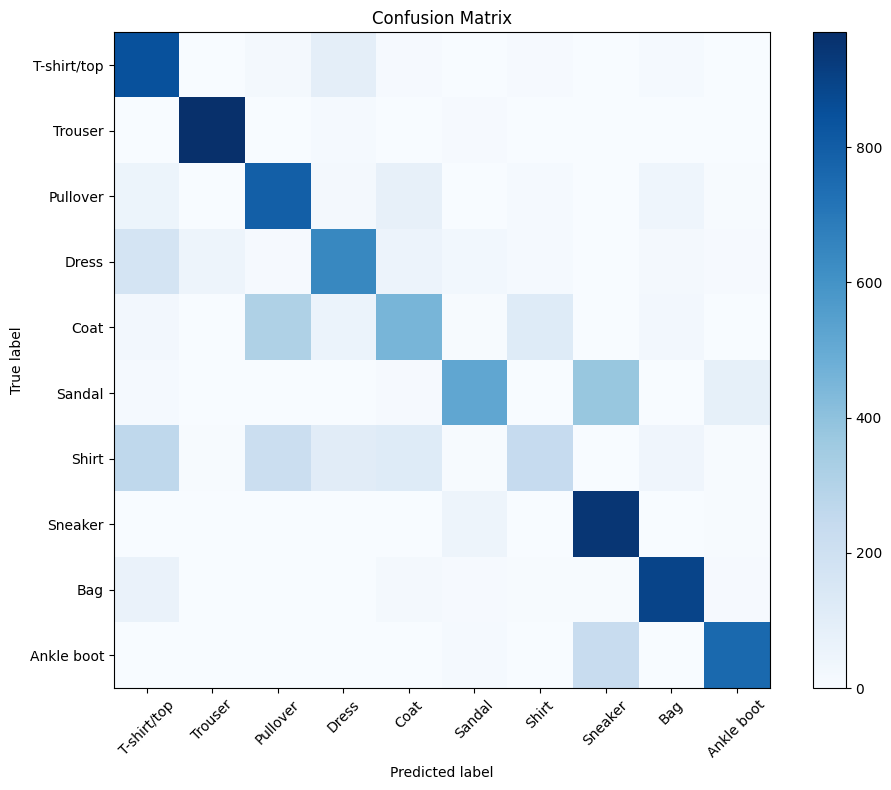

-------------------------
CONFUSIONS > CHANCE (10%)
-------------------------
Dress      => T-shirt/top  17.30%
Coat       => Pullover     31.20%
Coat       => Shirt        11.90%
Sandal     => Sneaker      37.70%
Shirt      => T-shirt/top  26.20%
Shirt      => Pullover     21.80%
Shirt      => Dress        10.70%
Shirt      => Coat         11.80%
Ankle boot => Sneaker      23.00%

-------------------------------
MODEL COMPARISON: TEST ACCURACY
-------------------------------
Baseline Zero-Shot CLIP:	62.40%
Prompted Zero-Shot CLIP: 	70.55%
Model accuracy difference: 	8.15%


In [29]:
# RESULTS: ACCURACY
msg = "results: prompt engineering-enhanced zero-shot classification "
headr = "="*(len(msg))
print(f"{headr}\n{msg.upper()}\n{headr}")
# print(test_dataset.classes)

msg = "test accuracy "
headr = "-"*(len(msg))
print(f"{headr}\n{msg.upper()}\n{headr}")

cm_prompt = confusion_matrix(y_true_prompt, y_pred_prompt)
class_acc = np.diag(cm_prompt)/cm_prompt.sum(axis=1)

# Report the accuracy of the predictions
print(f"Overall: \t{accuracy_score(y_true_prompt,y_pred_prompt)*100:.2f}%\n")
for item, score in list(zip(CLASS_NAMES,class_acc.tolist())):
    print(f"{item:<15} {score*100:.2f}%")

# RESULTS: CONFUSIONS
plot_confusion_matrix(y_true_prompt,y_pred_prompt, CLASS_NAMES)

msg = "confusions > chance (10%)"
headr = "-"*(len(msg))
print(f"{headr}\n{msg.upper()}\n{headr}")

# Normalize rows to percentages
row_sums = cm_prompt.sum(axis=1, keepdims=True)

percent_matrix = np.divide(
    cm_prompt,
    row_sums,
    out=np.zeros_like(cm_prompt, dtype=float),
    where=row_sums != 0
) * 100

percent_no_diag = percent_matrix.copy()
np.fill_diagonal(percent_no_diag, 0)

rows, cols = np.where(percent_no_diag > len(CLASS_NAMES))

for r, c in zip(rows, cols):
    print(f"{CLASS_NAMES[r]:<10} => {CLASS_NAMES[c]:<12} {percent_no_diag[r, c]:.2f}%")

# RESULTS: MODEL COMPARISON
msg = "Model Comparison: test accuracy"
headr = "-"*(len(msg))
print(f"\n{headr}\n{msg.upper()}\n{headr}")

CNN_acc = 90.65
ZSC_acc = accuracy_score(y_true,y_pred)*100
ZSCp_acc = accuracy_score(y_true_prompt,y_pred_prompt)*100

print(f"Baseline Zero-Shot CLIP:\t{ZSC_acc:.2f}%\n"
      f"Prompted Zero-Shot CLIP: \t{ZSCp_acc:.2f}%")
print(f"Model accuracy difference: \t{ZSCp_acc - ZSC_acc:.2f}%")

Reflection: How did your detailed prompts affect the zero-shot classification performance? Did you see a significant improvement compared to the baseline? What insights did you gain about the model's understanding of the classes? Do you think that with more effort you could further improve the performance? If so, how?

> Detailed prompts improved classification performance (70.6%) over baseline (62.4%) zero-shot by 8.15%. Inclusion of "a photo of" provided an immediate boost in performance. Shirt remained a difficult class to find performance gains on. This makes sense given the significant shape overlap between the top-wear items. Since the Fashion-MNIST images are very low resolution there is a loss of more detailed, high spatial frequency information, and CLIP seems to rely on detailed and visually descriptive language. CLIP was also trained using RGB images whereas Fashion-MNIST is grayscale, which results in a loss of texture information (in addition to colour). 
>
> I put some effort into getting the classifier above 70%, and my systematic approach outlined above was helpful for achieving that. The confusion between Sandal and Sneaker could likely be sorted out with a more detailed description - since the classifier was highly accurate with Sneaker, I added negation to the Sandal description for ease. Some of the suggestions for experiments given below (e.g., Top-K, different model) should further improve test accuracy.

## Visualizing Image Embeddings with UMAP

To better understand how the model perceives the different classes, we can visualize the image embeddings using UMAP (Uniform Manifold Approximation and Projection). UMAP is a dimensionality reduction technique that helps us see how similar or dissimilar the embeddings are in a lower-dimensional space.

By visualizing the embeddings, we can gain insights into how well the model can distinguish certain images, even without considering the text prompts. This can help us identify clusters of similar images and see if there are any overlaps between classes.

You should:

- [ ] Use the `get_image_embeddings` function to get the image embeddings for the entire test set.
- [ ] Use UMAP to reduce the dimensionality of the image embeddings to 2D.
- [ ] Plot the 2D embeddings, coloring each point by its true class label.

You may need to install the `umap-learn` library if you haven't already. You can do this by running `pip install umap-learn`.

In [30]:
# Uncomment the following line to install UMAP if you haven't already
# !pip install umap-learn

In [ ]:
from umap import UMAP

# ------------------------------------------------------------
# 1. Collect image embeddings
# ------------------------------------------------------------
all_img_emb = []
all_labels  = []

for pixel_values, labels in test_loader:
    # normalized embeddings
    img_emb = get_image_embeddings(pixel_values) 

    # extract and store image embeddings and labels
    all_img_emb.append(img_emb.cpu())
    all_labels.extend(labels.numpy())

# concatenate embeddings into array
all_img_emb = torch.cat(all_img_emb, dim=0).numpy()
all_labels = np.array(all_labels)

# ------------------------------------------------------------
# 2. Fit UMAP
# ------------------------------------------------------------
umap_reducer = UMAP(
    n_components = 2,
    n_neighbors = 15,
    random_state = 42    
)
embeddings_2d = umap_reducer.fit_transform(all_img_emb)


RESULTS: UMAP OF PROMPT-ENHANCED ZERO-SHOT CLASSIFICATION 
Image embeddings shape: (10000, 512)
Labels shape: (10000,)
Reduced embeddings shape: (10000, 2)


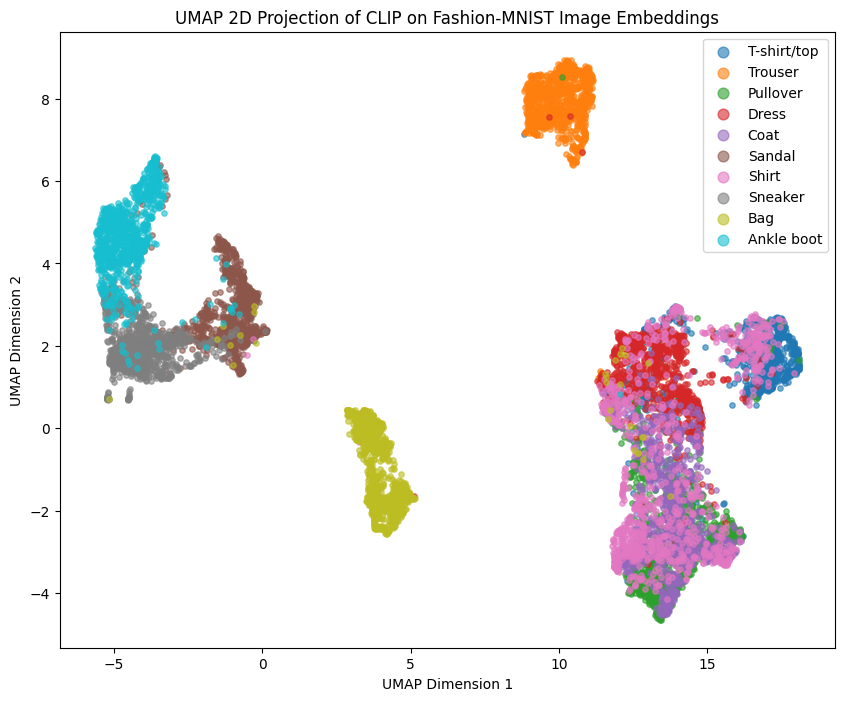

In [ ]:

# sanity checks
print(f"Image embeddings shape: {all_img_emb.shape}")
print(f"Labels shape: {all_labels.shape}")
print(f"Reduced embeddings shape: {embeddings_2d.shape}")

# ------------------------------------------------------------
# 3. Plot coloured by ground-truth label
# ------------------------------------------------------------
plt.figure(figsize=(10,8))
cmap = plt.get_cmap("tab10") # distinct 

# scatter plot points for each class
for idx, name in enumerate(CLASS_NAMES):
    mask = all_labels == idx
    plt.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        s = 15,
        alpha = 0.6,
        label = name,
        color = cmap(idx)
    )

plt.title('UMAP 2D Projection of CLIP on Fashion-MNIST Image Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(markerscale = 2)
plt.show() 

The UMAP embeddings allow us to see how separable or non-separable different classes are with our specific model. If two specific images are very similar, then they will be placed near each other on this graph. 

Reflection: Do you notice any challenges in distinguishing images based on this figure? Are there any types of clothing in the dataset which the model has no trouble distinguishing from the others?

> The UMAP figure is consistent with my previous observations: 
> 1) Fashion-MNIST is largely dependent upon shape information as indicated by the separability of the clusters representing Bag, Trouser, footwear (Sandal, Sneaker, Ankle Boot) and top-wear (Shirt, Coat, Pullover, T-shirt, Dress). 
> 2) Shirt is a poorly defined class that spants the entire top-wear cluster, consistent with its low accuracy and within category confusions.
> 3) I was successful in increasing separability of the footwear category with the descriptive prompts.
> 4) There is still room for the model to improve.

## Mini-Experiment

In this section, you will conduct a mini-experiment of your choice to further explore the capabilities of zero-shot classification with transformers. This can be anything you'd like, but here are some ideas to get you started.

### A. Alternative Model

So far we have been utilizing OpenAI's CLIP model for zero-shot classification. However, there are many other vision–language models available in the `transformers` library that you can experiment with. For example, there are larger CLIP models such as [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14), and open-source versions such as [laion/CLIP-ViT-B-32-laion2B-s34B-b79K](https://huggingface.co/laion/CLIP-ViT-B-32-laion2B-s34B-b79K). You can also search huggingface [here](https://huggingface.co/models?sort=trending&search=clip) to find other models that might be suitable for zero-shot classification.

You can try using a different model to see if it improves the zero-shot classification performance. You should:
- [ ] Load a different model and processor from the `transformers` library.
- [ ] Run the zero-shot classification baseline with the new model and report the accuracy and confusion matrix.
- [ ] Reflect on the performance of the new model compared to the original CLIP model
  - How does the new model perform compared to the original CLIP model?
  - Do you notice any differences in the types of errors made by the new model?

### B. Multiple-Description Classification

Another interesting experiment is to explore multiple-description classification. *This involves providing multiple text prompts for each class, allowing the model to choose the most relevant one. For example, instead of just "T-shirt/top", you could provide "a photo of a T-shirt", "a photo of a top", and "a photo of a shirt". This can help the model better understand the class and increases the likelihood of a correct prediction. You should:

- [ ] Create a list of multiple prompts for each class.
- [ ] Use the `get_text_embeddings` function to create text embeddings for the multiple prompts.
- [ ] Run the zero-shot classification baseline again using the multiple prompts and report the accuracy and confusion matrix.
- [ ] Consider the model to be correct if it guesses *any* of the prompts belonging to the correct class.

### C. Top-K Classification

In some classification tasks, it can be useful to consider if the right answer is among the top K (e.g. top 3) predictions. This can be particularly useful in cases where the model is uncertain or when there are multiple similar classes. You should:

- [ ] Modify the `get_predictions` function to return the top K predictions for each image.
- [ ] Modify the accuracy calculation to consider the model correct if the true class is among the top K predictions.
- [ ] Report the accuracy and confusion matrix for the top K predictions. Report at least two different values of K (e.g. K=2 and K=4).

### D. Other Ideas

You are welcome to come up with your own mini-experiment! Explain your idea in the report and implement it. Did it work as you expected? What did you learn from it?

## Mini-Experiment: Top-K Classification

**Introduction**

Since top-K is particularly useful in cases where model uncertainty is related to significant class similarity, I opted to experiment with top-k classification to further parse the topwear category, and specifically see how it would affect the Shirt class. I anticipate K=2 will be sufficient to boost model accuracy, though perhaps not to the same level as the trained CNN from assignment 1. 

**Hypothesis**

If many errors become correct under Top-2 that would suggest the embedding space is mostly right and that the argmax boundary is the bottleneck in test accuracy, rather than the quality of the descriptions. It would also provide further support that the confusions are primarily due to semantic differences, rather than random. If accuracy increases dramatically, it suggests the model does indeed understand semantic structure but has overlapping clusters. If on the other hand accuracy increases minimally, it suggests the embedding space itself has significant representational overlap. If we had access to human labelling data, I would expect inter-observer variance to be highest for Shirts relative to other classes within the topwear category. 

In [33]:
# DEFINE FUNCTIONS
# find top K cosine similarity predictions
def get_predictions_top_k(similarity: np.ndarray, k: int = 1) -> np.ndarray:
    """
    Get the top K predictions based on cosine similarity scores.
    Args:
        similarity (numpy.ndarray): Cosine similarity matrix of shape (N, M), 
            where N is the number of images and M is the number of text prompts.
        k (int): # top predictions to return; defaults to 1
    Returns:
        numpy.ndarray: Predicted class indices for each image, shape (N,k),
            where N is the number of images and k is the number of predictions
    """
    # Get the index of the top K similarity for each image
    return np.argsort(similarity, axis=1)[:, ::-1][:, :k] # sort desc and return top

# calculate top K accuracy
def top_k_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """ 
    Calculate top-K accuracy based on y_true in y_pred
    Args:
        y_true (numpy.ndarray): true labels matrix of shape (N, ),
            where N is the number of images
        y_pred (numpy.ndarray): top-k predictions matrix of shape (N, k)
            where N is the number of images and k is the number of predictions
    Returns:
        float: top-K accuracy
    """
    matches = (y_pred == y_true[:, None])
    top_k_acc = np.mean(matches.any(axis=1))
    return (top_k_acc)

def top_k_hit_rate_per_class(y_true, y_pred, k, class_names):
    """
    Returns: dict of Top-K hit rate per class
    """
    hr = (y_pred[:, :k] == y_true[:, None]).any(axis=1)
    hr_per_class = {}
    for idx, name in enumerate(class_names):
        mask = (y_true == idx)
        hr_per_class[name] = hr[mask].mean()
    return hr_per_class

In [ ]:
# RUN EXPERIMENT
k_vals = [1, 2, 3, 5] # top-k values to explore
results_k = {}

# 1. Build text embeddings for class names (done above)
# text_embeddings_prompt = get_text_embeddings(improved_prompt)

# 2. Loop through Top-K candidates
for k in k_vals:
    y_true_k, y_pred_k = [], []

    # 3. Get classification predictions for each batch
    for pixel_values, labels in test_loader:
        
        image_embeddings = get_image_embeddings(pixel_values)
        similarity = get_cosine_similarity(image_embeddings, text_embeddings_prompt)
        predictions_k = get_predictions_top_k(similarity, k)

        y_pred_k.append(predictions_k)  # predictions
        y_true_k.extend(labels.numpy()) # ground truth

    # 4. Convert to array
    y_true_k = np.array(y_true_k)
    y_pred_k = np.vstack(y_pred_k)

    # 5. Calculate & store prediction accuracy
    acc_k = top_k_accuracy(y_true_k, y_pred_k)

    # store in dict for future use
    results_k[k] = {
        'accuracy': acc_k,
        'predictions': y_pred_k,
        'labels': y_true_k
    }


MINI-EXPERIMENT RESULTS: TOP-K CLASSIFICATION


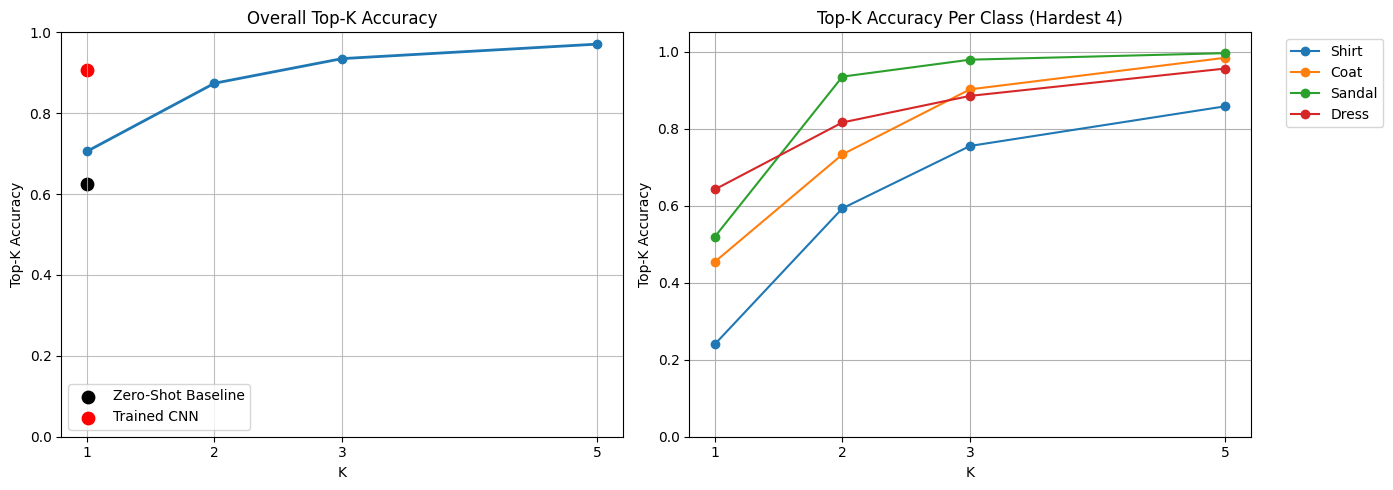

----------------------------------------------------------------
MODEL COMPARISONS VS ZERO-SHOT BASELINE AND RELATIVE IMPROVEMENT
----------------------------------------------------------------
Model                     Accuracy (%)   Δ Base (%)   Δ Prev (%)
Baseline Zero-Shot CLIP       62.40         0.00         0.00
Prompted Zero-Shot CLIP       70.55         8.15         8.15
Top-2 Classification          87.41        25.01        16.86
Top-3 Classification          93.50        31.10         6.09
Top-5 Classification          97.09        34.69         3.59

------------------------------------------
PER-CLASS IMPROVEMENT % Δ(TOP-3 VS TOP-1) 
------------------------------------------
             Top-1  Top-3  Δ(3-1)
Shirt         24.0   75.5    51.5
Coat          45.4   90.2    44.8
Sandal        51.9   97.9    46.0
Dress         64.2   88.5    24.3
Ankle boot    75.6   99.8    24.2
Pullover      79.2   92.6    13.4
T-shirt/top   84.6   95.2    10.6
Bag           89.2   95.7   

In [ ]:
import pandas as pd

# overall
top_k_acc = [results_k[k]['accuracy'] for k in k_vals]

# per-class 
all_hits = {}
for k in k_vals:
    y_true = results_k[k]['labels']
    y_pred = results_k[k]['predictions']
    all_hits[f'Top-{k}'] = top_k_hit_rate_per_class(y_true, y_pred, k, CLASS_NAMES)

df_all = pd.DataFrame(all_hits)
df_all = df_all.sort_values('Top-1', ascending=False) # sort by Top-1

# improvements
improvement = (df_all['Top-3'] - df_all['Top-1']) * 100
improvement_sorted = improvement.sort_values(ascending=False)
class_order = improvement_sorted.index
hardest_classes = df_all.sort_values('Top-1').index[:4]

# RESULTS: FIGURES
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# LEFT: Overall Top-K
axes[0].plot(k_vals, top_k_acc, marker='o', linewidth=2)
axes[0].scatter(1, ZSC_acc/100, color="black", s=80, label="Zero-Shot Baseline")
axes[0].scatter(1, CNN_acc/100, color="red", s=80, label="Trained CNN")
axes[0].set_xticks(k_vals)
axes[0].set_ylim(0, 1.0)
axes[0].set_xlabel("K")
axes[0].set_ylabel("Top-K Accuracy")
axes[0].set_title("Overall Top-K Accuracy")
axes[0].grid(True, alpha=0.8)
axes[0].legend()

# RIGHT: Per-Class Top-K (Hardest)
for cls in hardest_classes:
    axes[1].plot(
        k_vals, 
        df_all.loc[cls].values,
        marker='o',
        linewidth=1.5,
        label=cls
    )

axes[1].set_xticks(k_vals)
axes[1].set_ylim(0, 1.05)
axes[1].set_xlabel("K")
axes[1].set_ylabel("Top-K Accuracy")
axes[1].set_title("Top-K Accuracy Per Class (Hardest 4)")
axes[1].grid(True)
axes[1].legend(bbox_to_anchor=(1.05,1), loc="upper left")

plt.tight_layout()
plt.show()

# RESULTS: MODEL COMPARISON
msg = "Model Comparisons vs zero-shot baseline and relative improvement"
headr = "-"*(len(msg))
print(f"{headr}\n{msg.upper()}\n{headr}")

model_results = [
    ("Baseline Zero-Shot CLIP", ZSC_acc, 0, 0),
    ("Prompted Zero-Shot CLIP", ZSCp_acc, ZSCp_acc - ZSC_acc, ZSCp_acc - ZSC_acc),
    ("Top-2 Classification   ", top_k_acc[1]*100, top_k_acc[1]*100 - ZSC_acc, top_k_acc[1]*100 - ZSCp_acc),
    ("Top-3 Classification   ", top_k_acc[2]*100, top_k_acc[2]*100 - ZSC_acc, top_k_acc[2]*100 - top_k_acc[1]*100),
    ("Top-5 Classification   ", top_k_acc[3]*100, top_k_acc[3]*100 - ZSC_acc, top_k_acc[3]*100 - top_k_acc[2]*100)
]

print(f"{'Model':25} {'Accuracy (%)':>5} {'Δ Base (%)':>12} {'Δ Prev (%)':>12}")

for label, acc, bl, prev in model_results:
    print(f"{label:24} {acc:10.2f} {bl:12.2f} {prev:12.2f}")

msg = "per-class improvement % Δ(Top-3 vs Top-1) "
headr = "-"*(len(msg))
print(f"\n{headr}\n{msg.upper()}\n{headr}")

# # RESULTS: PER-CLASS TOP-K (4 hardest)
# df_all['Δ(3-1)'] = df_all['Top-3'] - df_all['Top-1']
# hardest_classes = df_all.sort_values('Top-1').index[:4]
# small_table = ((df_all.loc[hardest_classes, ['Top-1','Top-3','Δ(3-1)']]) * 100).round(2)
# print(small_table)

# RESULTS: PER-CLASS TOP-K (all)
df_all['Δ(3-1)'] = df_all['Top-3'] - df_all['Top-1']
hardest_classes = df_all.sort_values('Top-1').index[:]
delta_table = ((df_all.loc[hardest_classes, ['Top-1','Top-3','Δ(3-1)']]) * 100).round(2)
print(delta_table)


### Short Report

In this section, you will write a short report summarizing your findings from the mini-experiment. The report should include the following sections:

- **Introduction**: Briefly describe the mini-experiment you conducted and its objectives.
- **Methodology**: Explain the steps you took to conduct the experiment, including any modifications you made to the code or model.
- **Results**: Present the results of your experiment.
- **Discussion**: Reflect on the performance of the model and the implications of your findings. Consider the strengths and weaknesses of zero-shot transformers versus a trained CNN.

## Top-K Zero-Shot Classification on Fashion-MNIST

### Introduction 
The objective of this mini-experiment was to explore the performance of zero-shot image classification using a CLIP-based model on the Fashion-MNIST dataset. Specifically, I explored how the model's accuracy improves when considering the top K predicted labels for each image (Top-K classification). This approach allows us to examine structural uncertainty in the model's predictions, highlighting how often the correct class appears among the top few guesses even when the Top-1 prediction is incorrect.

### Methodology
**1. Model and Dataset**:
- prompted zero-shot CLIP model (ViT-B/32) as the main model
- Fashion-MNIST test set (grayscale, low-resolution) for evaluation

**2. Top-K Prediction Implementation**:
- the function `get_predictions_top_k()` was modified to return the top K predicted classes based on cosine similarity between image and text embeddings
- Top-K accuracy was calculated using a vectorized function, `top_k_accuracy()`, which counts a prediction as correct if the true label appears amongst the top K predictions
- per-class Top-K hit rate was calculated using `top_k_hit_rate_per_class()`

**3. Procedure**:
- compute Top-K predictions for K = [1, 2, 3, 5]
- record overall Top-K accuracy and per-class accuracy
- calculate per-class improvement, Δ(Top-3 vs Top-1)
- compare results to a baseline and prompt-enhanced zero-shot CLIP model
- identified the hardest 4 classes (lowest Top-1 accuracy) to examine how much the Top-K predictions recover these overlapping categories

### Results
Top-K evaluation revealed that structured uncertainty is present: by K=3 accuracy rises to 93.5% and by K=5 the model reaches 97.1%, values that exceed the supervised CNN model (90-92%) from Assignment 1. There are dimished performance gains as Top-K increases, with the biggest increase in model performance observed when moving from Top-1 (70.6%) to Top-2 (87.4%), at nearly 17% improvement, compared to 6.1% and 3.5% for Top-2 to Top-3 and Top-3 to Top-5, respectively. 

Per-class analysis highlights that certain classes (e.g., Shirt, Coat, Sandal) are particularly challenging at Top-1, but much of the error is recovered in Top-3 predictions (~44%-52%). On the other hand, classes with very high Top-1 accuracy (e.g., Trouser, Sneaker) showed minimal improvement (<10%) with Top-K, indicating that these categories are reliably classified and semantically distinct. These findings are consistent with the UMAP figure.

### Discussion
The baseline zero-shot CLIP model, which used only the class labels, achieved test accuracy of 62.4%. The prompt-enhanced zero-shot CLIP model (Top-1) performed better (70.6%) than baseline by roughly 8%. Although this was a significant improvement, examination of the confusion matrix and UMAP projections both indicated significant semantic overlap in the embeddings. To explore whether model uncertainty was related to significant class similarity, I assessed a range of Top-K values to compare with the Top-1 prompt-enhanced model. 

The large increase in test accuracy under Top-2 classification suggests that the model confusions are primarily due to semantic differences in the text embeddings. In other words, the CLIP model captures semantic structure, despite the highly overlapping clusters found in the Fashion-MNIST dataset.

More generally, the results suggest that:
- zero-shot transformers are capable of meaningful ranking of predictions even when the top guess is wrong
- difficulty is concentrated in visually or semantically similar categories, consistent with human perceptual confusions
- compared to a trained CNN, zero-shot CLIP provides competitive performance without supervised training, though CNNs may achieve higher Top-1 accuracy for well-separated categories

### Conclusion
Top-K analysis provides a richer picture of model performance than Top-1 accuracy alone. Structured uncertainty and per-class recovery reveal that zero-shot transformers encode perceptual similarity in a meaningful way, making them particularly informative for exploratory or low-data scenarios.


🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 02/11/2025`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb)
    * The Lab 4 notebook (labs/lab_4.ipynb)
    * The Lab 5 notebook (labs/lab_5.ipynb)
    * The Lab 6 notebook (labs/lab_6.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-7-help-ml`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.